In [1]:
import glob
import re
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import dja_sepp

## Catalog

In [3]:
home = "/FlashStorage/"
field = 'ceers-full-grizli-v7.2'
fit = 'sersic_rg4'

In [6]:
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
phot_tiles = []
tiles = glob.glob(f"{home}/fields/{field}/sepp/{fit}/*sci_tile-[!full]*sepp_cat.fits")
tiles.sort(key=lambda filename: int(''.join(filter(str.isdigit, filename))))
for tile in tiles:
    with fits.open(tile) as hdul:
        phot_tiles.append(Table(hdul[1].data))

In [7]:
print(f"{'Sources in DJA catalog':<28} : {len(phot_dja)}")
# print(phot_dja.keys())
for i, tile in enumerate(phot_tiles):
    print(f"{f'Sources in SE++ catalog ({i})':<28} : {len(tile)}")
    # print(len(tile.keys()))

Sources in DJA catalog       : 76637
Sources in SE++ catalog (0)  : 21585
Sources in SE++ catalog (1)  : 22681
Sources in SE++ catalog (2)  : 14161
Sources in SE++ catalog (3)  : 20753
Sources in SE++ catalog (4)  : 9320


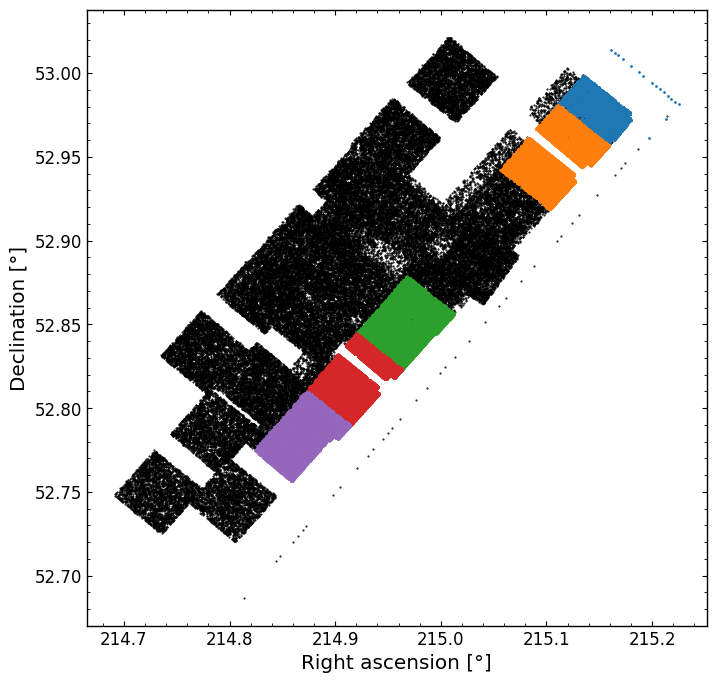

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
for i, tile in enumerate(phot_tiles):
    ax.plot(tile['world_centroid_alpha'], tile['world_centroid_delta'], marker='o', ls='', ms=1, label=f'SE++ ({i})')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.86, 214.98)
# ax.set_ylim(52.82, 52.90)
# ax.legend()
plt.show()

In [9]:
phot_full = dja_sepp.merge_tiles(phot_tiles)
name = re.sub('tile-\d+','tile-full',tiles[0].split('/')[-1])
phot_full.write(f"{home}/fields/{field}/sepp/{fit}/{name}", format='fits', overwrite=True)

## Images

In [1]:
import glob
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
import dja_sepp

home = "/FlashStorage/"
field = 'ceers-full-grizli-v7.2'
fit = 'B+D'
with fits.open(glob.glob(f"{home}/fields/{field}/sepp/*sci_tile-full*sepp_cat.fits")[0], memmap=True) as hdul:
    phot_full = Table(hdul[1].data)
filter_list = dja_sepp.get_filter_list(phot_full.keys())
# filter_list = ['f115w', 'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f356w', 'f410m', 'f444w']
with fits.open(glob.glob(f"{home}/fields/{field}/image/*f115w*.fits")[0], memmap=True) as hdul:
    hdu = hdul[0]
    wcs = WCS(hdu.header)
    shape = hdu.data.shape
print("====== Model =======")
dja_sepp.merge_images(f"{home}/fields/{field}/sepp/{fit}/checkimages", filter_list, wcs=wcs, shape=shape, 
                      type='model', suffix="*sci_tile-[!full]*", verbose=True)

====== Model =======
---- F150W ----
F150W : ['/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/B+D/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-6_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/B+D/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-14_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/B+D/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-24_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/B+D/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-26_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/B+D/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-11_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/B+D/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-3_1.fits', '/FlashStorage//fields/ceers-full-grizli-v7.2/sepp/B+D/checkimages/model_ceers-full-grizli-v7.2-f150w-clear_drc_sci_tile-17_1.fits', '/FlashStorage//fields/ce

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN' 'DEC--TAN' 
 CRVAL : 214.92 52.87 
 CRPIX : 18432.0 6144.0 
 CD1_1 CD1_2  : -7.1420845520725e-06 -8.5116049235441e-06 
 CD2_1 CD2_2  : -8.5116049235441e-06 7.14208455207265e-06 
 NAXIS : 36864  12288,
 (12288, 36864))

In [2]:
for filter in filter_list:
    print(f"---- {filter.upper()} ----")
    with fits.open(glob.glob(f"{home}/fields/{field}/image/*{filter}*.fits")[0], memmap=True) as hdul:
        hdu_data = hdul[0]
        with fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0], memmap=True) as hdul_model:
            hdu_model = hdul_model[0].copy()
        hdu_model.header = hdu_data.header
        hdu_model.writeto(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0], overwrite=True)
        
        data_resid = hdu_data.data - hdu_model.data
        hdu_resid = fits.PrimaryHDU(data_resid, hdu_data.header)
        name = glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0].replace('model', 'resid')
        hdu_resid.writeto(name, overwrite=True)

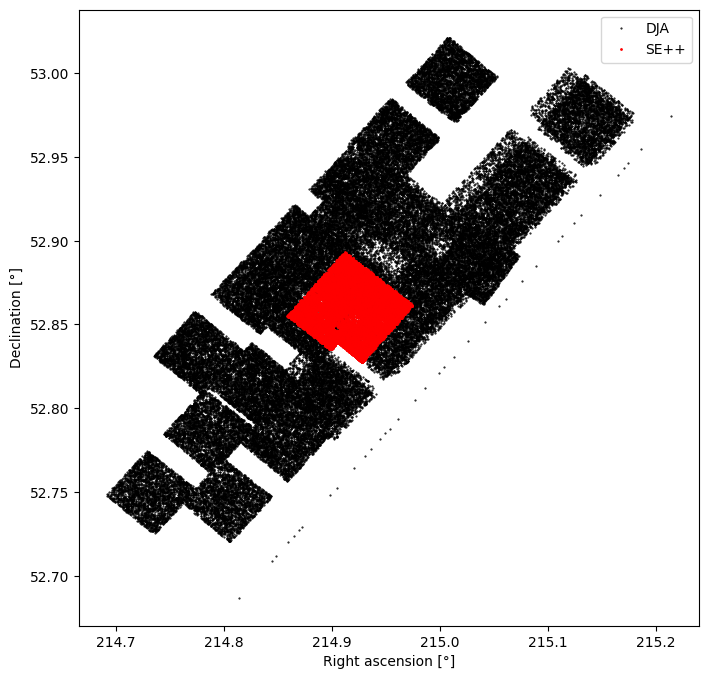

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_full['world_centroid_alpha'], phot_full['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label=f'SE++')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.86, 214.98)
# ax.set_ylim(52.83, 52.90)
ax.legend()
plt.show()

In [61]:
from astropy.visualization import ImageNormalize, ZScaleInterval, MinMaxInterval, LogStretch
from astropy.wcs import WCS
from matplotlib.gridspec import GridSpec
import numpy as np

filter = 'f200w'
images = glob.glob(f"{home}/fields/{field}/sepp/checkimages/model*{filter}*tile-[!full]*.fits")
# images = glob.glob(f"{home}/fields/{field}/sepp/checkimages/resid*{filter}*tile-[!full]*.fits")
# images = glob.glob(f"{home}/fields/{field}/image/tiles/*{filter}*sci*tile-[!full]*.fits")
images

['/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/sepp/checkimages/model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_cutout_tile-0_1.fits',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/sepp/checkimages/model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_cutout_tile-1_1.fits',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/sepp/checkimages/model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_cutout_tile-2_1.fits',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/sepp/checkimages/model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_cutout_tile-3_1.fits',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/sepp/checkimages/model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_cutout_tile-4_1.fits',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/sepp/checkimages/model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_cutout_tile-5_1.fits',
 '/home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/sepp/checkimages/model_ceers-full-grizl

0 513.31323
1 513.8622
2 2328.001
3 80.71063
4 0.0
5 471.29532
6 86.23335
7 139.95203
8 1067.7692


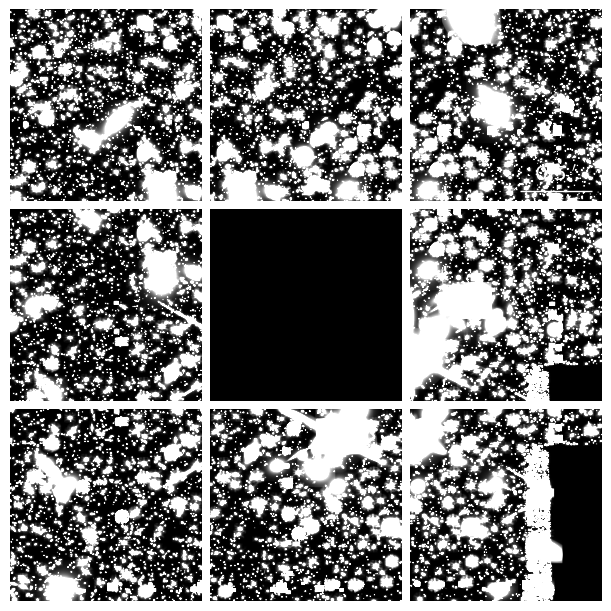

In [62]:
tiles = [fits.open(img, memmap=True)[0] for img in images]

nx, ny = 3, 3

h, w = tiles[0].data.shape
plot_x_size = min(12, 2*nx)
plot_y_size = min(8, plot_x_size*ny/nx*h/w)
plot_x_size = min(12, plot_y_size*nx/ny*w/h)

fig = plt.figure(layout='constrained', figsize=(plot_x_size,plot_y_size))
gs = GridSpec(ny, nx, figure=fig)
norm = ImageNormalize(tiles[0].data, interval=ZScaleInterval())
# norm = ImageNormalize(tiles[0].data, interval=MinMaxInterval(), stretch=LogStretch())
for j in range(ny):
    for i in range(nx):
        tile = tiles[i+nx*j]
        print(i+nx*j, np.max(tile.data))
        wcs = WCS(tile.header)
        ax = fig.add_subplot(gs[ny-j-1,i], projection=wcs)
        # norm = ImageNormalize(tile.data, interval=ZScaleInterval())
        ax.imshow(tile.data, cmap='gray', origin='lower', norm=norm)
        ax.set_axis_off()
        if (j==ny-1) & (i==nx-1):
            dja_sepp.utils.add_good_scalebar(ax, wcs, fraction=0.5)
plt.show()

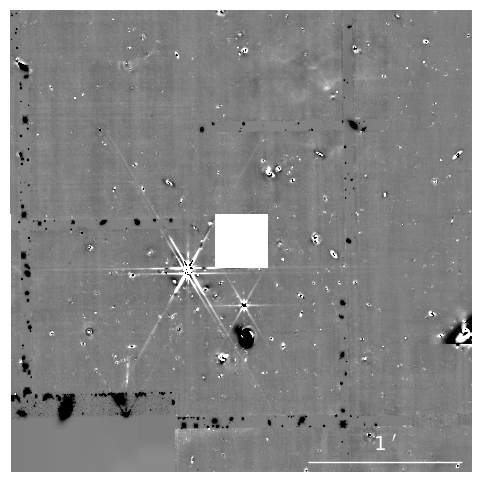

In [64]:
# full = glob.glob(f"{home}/fields/{field}/sepp/checkimages/model*{filter}*tile-full*.fits")[0]
full = glob.glob(f"{home}/fields/{field}/sepp/checkimages/resid*{filter}*tile-full*.fits")[0]
# full = glob.glob(f"{home}/fields/{field}/image/tiles/*{filter}*sci*tile-full*.fits")[0]
img = fits.open(full, memmap=True)[0]

wcs = WCS(img.header)
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':wcs})
norm = ImageNormalize(img.data, interval=ZScaleInterval())
ax.imshow(img.data, cmap='gray', origin='lower', norm=norm)
ax.set_axis_off()
dja_sepp.utils.add_good_scalebar(ax, wcs, fraction=0.5)
plt.show()